In [1]:
from itertools import permutations
import pandas as pd
import numpy as np
import qutip
import matplotlib.pyplot as plt
import seaborn
import time
%matplotlib inline

In [25]:
stateslen=[2,4,6,8,10]
sty=stateslen[4]
initialstate='10'*(sty/2)
length=len(initialstate)
b=list(permutations(initialstate))
b=list(set(b))

def listtostr(l):
    s=''
    for i in l:
        s=s+str(i)
    return s

def strlist(b):
    index = []
    for li in b:
        index.append(listtostr(li))
    return index

def find_rel_sta(a):
    rel_sta=[]
    tm=len(a)-1
    a=[int(x) for x in a]
    for i in range(len(a)-1):
        if a[i]!=a[i+1]:
            sta = a[:]
            tm = tm-2
            sta[i],sta[i+1]=sta[i+1],sta[i]
            rel_sta.append(sta)
    return rel_sta,tm

index = strlist(b)
dim = len(index)
initialstateindex = index.index(listtostr(initialstate))

In [26]:
s=pd.DataFrame(np.zeros((dim,dim)),index=index,columns=index)
for i in range(dim):
    s[index[i]][strlist(find_rel_sta(index[i])[0])]=0.5
    s.iloc[i][i]=0.25*find_rel_sta(index[i])[1]

Hamiltonian=4*qutip.Qobj(s.as_matrix())
eigsta=Hamiltonian.eigenstates()[1]
eigen=Hamiltonian.eigenstates()[0]
print Hamiltonian

Quantum object: dims = [[252], [252]], shape = (252, 252), type = oper, isherm = True
Qobj data =
[[-1.  0.  0. ...,  0.  0.  0.]
 [ 0. -1.  0. ...,  0.  0.  0.]
 [ 0.  0. -3. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ..., -3.  0.  0.]
 [ 0.  0.  0. ...,  0. -1.  0.]
 [ 0.  0.  0. ...,  0.  0.  1.]]


In [27]:
# Antiferromagnetic State
AFRho = qutip.basis(dim,index.index('10'*(length/2)))
# Phase Separated State
# PSRho = qutip.basis(dim,index.index('0'*length/2+'1'*length/2))
# # Random States
# tmp = np.random.rand(dim,1)
# tmp = (tmp/np.sum(tmp))**0.5
# RandRho = qutip.Qobj(tmp)
# # Mixed states
# MixRho = (qutip.ket2dm(AFRho)+qutip.ket2dm(PSRho))/2.0

# States={'AFRho':AFRho,'PSRho':PSRho,'RandRho':RandRho,'MixRho':MixRho}
# Keys=['AFRho','PSRho','RandRho','MixRho']

In [28]:
def generHa(index):
    disoHa=np.zeros((dim,dim))
    b = np.random.normal(0,1,len(initialstate))
    for i in range(dim):
        a=np.array(list(index[i]),dtype='int16')
        disoHa[i][i]=np.sum(-b*((-1)**a))
    return disoHa

def run(t,eta,inistate):
    tmps=qutip.mesolve(Hamiltonian+generHa(index),inistate,[0,t],[])
    for i in range(eta-1):
        tmps=qutip.mesolve(Hamiltonian+generHa(index),tmps.states[1],[0,t],[])
    return [qutip.expect(qutip.ket2dm(qutip.basis(dim,i)),tmps.states[1]) for i in range(dim)]

def genPurierror(test,initialstate,NU=500):
    if qutip.isket(initialstate):
        pur = (qutip.ket2dm(initialstate)*qutip.ket2dm(initialstate)).tr()
    elif qutip.isoper(initialstate):
        pur = (initialstate*initialstate).tr()
    else:
        print 'Wrong State form'
    test=np.array(test)
    average1 = np.sum(test,axis=0)/NU 
    average2 = np.sum(test*test,axis=0)/NU
    return np.average(average2*dim*(dim+1)-(average1*dim)**2-pur)

def gen_vag_er(t,eta,times,inistate,NU=500):
    error=[]
    for j in range(times):
        test=[]
        for i in range(NU):
            Pe=run(t,eta,inistate)
            test.append(Pe)
        error.append(genPurierror(test,inistate,NU))
    return np.average(np.abs(error))

In [6]:
# Eretalen={}
# for i in stateslen:
#     Eretalen[i]={}

# print Eretalen

{8: {}, 2: {}, 4: {}, 10: {}, 6: {}}


In [29]:
start=time.clock()
start0=start

for eta in [1,5,15,25,40,70]:
    Eretalen[sty][str(eta)]=gen_vag_er(1,eta,10,AFRho,NU=500)
    print str(eta)+': ',Eretalen[sty][str(eta)]
    print time.clock()-start,'s'
    start=time.clock()
print '_'*50
    
print 'Total time: ',time.clock()-start0,'s'
print Eretalen

1:  3.28491300128
679.25271 s
5:  0.334479845877
899.947372 s
15:  0.00550808644161
1434.8744 s
25:  0.00527321099472
1965.369101 s
40:  0.00405461257645
2766.236601 s
70:  0.0057851003079
4372.600466 s
__________________________________________________
Total time:  12118.281948 s
{8: {'12': 0.014152834135212251, '20': 0.013717662433642308, '32': 0.0072804568046989466, '56': 0.010511613269219202, '1': 1.3822358431433959, '4': 0.29828778647840148}, 2: {'1': 0.016664714653283619, '10': 0.016112604919861051, '16': 0.01393440655108304, '2': 0.0734163622628696, '6': 0.022807566236699682}, 4: {'10': 0.016926602441749629, '20': 0.024822726622543423, '32': 0.023428088599171493, '1': 0.036721913898880847, '2': 0.018693952507221591, '6': 0.029299361950051374}, 10: {'25': 0.0052732109947170643, '15': 0.0055080864416118007, '40': 0.004054612576447513, '1': 3.2849130012822649, '5': 0.33447984587708812, '70': 0.0057851003078950728}, 6: {'24': 0.018097344762072552, '15': 0.010816737884543848, '42': 0

In [54]:
print Eretalen

{8: {'28': 0.007802683776780654, '12': 0.1284862672835323, '20': 0.025107515434219768, '4': 1.0112695336415807, '40': 0.0072849918495225523}, 2: {'10': 0.021505690249683879, '20': 0.011279031310286796, '1': 0.30882074435244533, '3': 0.04661535629225759, '5': 0.064803741134634357, '15': 0.017956245829292367}, 4: {'10': 0.010842259917152226, '2': 0.28574836852555768, '28': 0.030085525958305388, '14': 0.012356736390313658, '6': 0.017195182252570215}, 10: {'10': 0.48911124195610478, '20': 0.06771224974020533, '40': 0.0053026294953989377, '60': 0.0040583895140149564, '3': 2.9353644986931213, '5': 1.7048763813848655, '80': 0.0035663968296958367}, 6: {'9': 0.057146525251691463, '42': 0.014525487168670947, '3': 0.35613633845577808, '15': 0.017065207375401167, '21': 0.021151483723703731}}


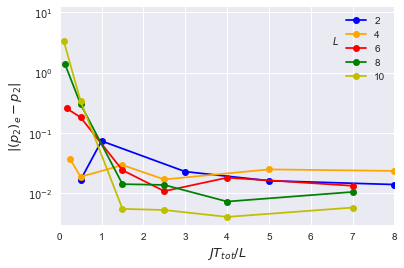

In [32]:
timeli = np.sort(np.array(Eretalen[stateslen[0]].keys(),dtype='int'))
plt.plot(1.0*timeli/stateslen[0],[Eretalen[stateslen[0]][str(i)] for i in timeli],'bo-')
timeli = np.sort(np.array(Eretalen[stateslen[1]].keys(),dtype='int'))
plt.plot(1.0*timeli/stateslen[1],[Eretalen[stateslen[1]][str(i)] for i in timeli],'o-',color='orange')
timeli = np.sort(np.array(Eretalen[stateslen[2]].keys(),dtype='int'))
plt.plot(1.0*timeli/stateslen[2],[Eretalen[stateslen[2]][str(i)] for i in timeli],'ro-')
timeli = np.sort(np.array(Eretalen[stateslen[3]].keys(),dtype='int'))
plt.plot(1.0*timeli/stateslen[3],[Eretalen[stateslen[3]][str(i)] for i in timeli],'go-')
timeli = np.sort(np.array(Eretalen[stateslen[4]].keys(),dtype='int'))
plt.plot(1.0*timeli/stateslen[4],[Eretalen[stateslen[4]][str(i)] for i in timeli],'yo-')
plt.yscale('log')
plt.xlabel(r'$JT_{tot}/L$',fontsize=13)
plt.ylabel(r'$|(p_2)_e-p_2|$',fontsize=13)
plt.text(6.5,3,r'$L$')
plt.xlim(0,8)
plt.ylim(0.003,12)
plt.legend(stateslen)
plt.savefig('differentlength.pdf',format='pdf',orientation='portrait',papertype='executive')

In [33]:
df=pd.DataFrame(Eretalen)
df.to_csv('differentlength.csv')
df.sort_values(by=[2,10])

,2,4,6,8,10
16,0.013934,NaN,NaN,NaN,NaN
10,0.016113,0.016927,NaN,NaN,NaN
1,0.016665,0.036722,0.254283,1.382236,3.284913
6,0.022808,0.029299,NaN,NaN,NaN
2,0.073416,0.018694,NaN,NaN,NaN
40,NaN,NaN,NaN,NaN,0.004055
25,NaN,NaN,NaN,NaN,0.005273
15,NaN,NaN,0.010817,NaN,0.005508
70,NaN,NaN,NaN,NaN,0.005785
5,NaN,NaN,NaN,NaN,0.334480
